In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
import pybaselines

Welcome to JupyROOT 6.30/04


In [2]:
FILE_PATH = "../Dati/Ortopositronio/run_chall_ortho_batch_aaAscii_0000.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [3]:
print(type(file["tree"]["base"].array()))
bl=file["tree"]["base"].array()
print(ak.num(bl))
#bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

nch=file["tree"]["ch"].array()
print(nch)

<class 'awkward.highlevel.Array'>
[16, 16, 16, 16, 16, 16, 16, 16, 16, ..., 16, 16, 16, 16, 16, 16, 16, 16, 13]
[13, 16]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ..., [0, 1, ..., 12]]


In [4]:
baselines = np.array(file["tree"]["base"])[1:-1] 
charges = np.array(file["tree"]["charge"])[1:-1]
amp = np.array(file["tree"]["amp"])[1:-1]
lead_edge = np.array(file["tree"]["letime"])[1:-1]
t_edge = np.array(file["tree"]["tetime"])[1:-1]
channel= np.array(file["tree"]["ch"])[1:-1]
waveform = np.array(file["tree"]["pshape"])[1:-1]


In [89]:
print(amp.shape)
print(charges.shape)
print(len(amp))

(254,)
(254,)
254


In [94]:
len(np.where(amp[0]>-1.2)[0])==16

True

In [97]:
print(channel)

9


In [7]:

mask=[len(np.where(amp[i]>-1.2)[0])==16 for i in range(len(amp))]
print(mask)
baselines=baselines[mask]
charges=charges[mask]
amp=amp[mask]
lead_edge=lead_edge[mask]
t_edge=t_edge[mask]
channel=channel[mask]
waveform=waveform[mask]

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [20]:
print(len(amp))
Nev=len(amp)

180


(180,)
channel: 3 baseline: 3.8e-05 charge -2063.679 lead_edge 391.914 trailing_edge -0.013
channel: 11 baseline: -0.000267 charge -444.488 lead_edge 256.565 trailing_edge 64.773
channel: 13 baseline: 0.000915 charge -212.563 lead_edge 313.895 trailing_edge 305.405


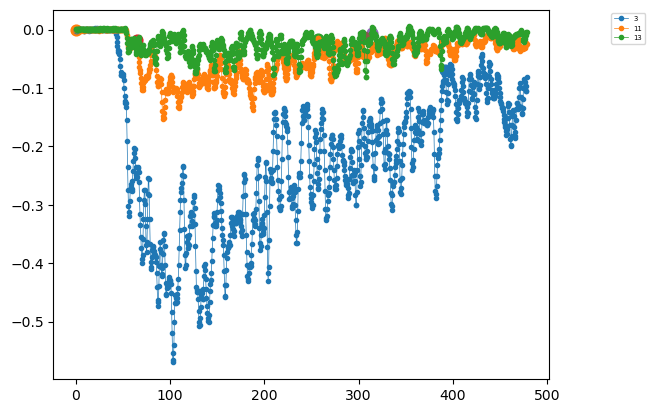

In [30]:
print(waveform.shape)
event=1
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
list=[3,11,13]
sampling=0.468
for channel in list:
    time=np.arange(1024)
    plt.plot(time*sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
    print("channel:", channel, "baseline:",  baselines[event][channel],"charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel] )
    t1=lead_edge[event][channel]
    t2=t_edge[event][channel]
    #print(t1,t2)
    plt.scatter( t1, waveform[event][channel][int(t1/sampling)],s=60   )
    plt.scatter( t2, waveform[event][channel][int(t2/sampling)],s=60  )
    #plt.xlim(400,600)
    #plt.ylim(-0.01, 0.1)

plt.legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))

In [24]:
interesting_channels=np.where(charges[ev]<-50)[0])

<class 'numpy.ndarray'>


In [28]:
###pulizia
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
true_charges=[]
true_amps=[]
true_channels=[]
true_waveforms=[]
true_ledge=[]
for ev in range(Nev):
    interesting_channels=np.where(charges[ev]<-50)[0] #canali che hanno visto qualcosa
    true_channels.append(interesting_channels.tolist())
    true_charges.append([charges[ev][ch] for ch in interesting_channels])
    true_amps.append([amp[ev][ch] for ch in interesting_channels])
    true_waveforms.append([waveform[ev][ch] for ch in interesting_channels])
    true_ledge.append([lead_edge[ev][ch] for ch in interesting_channels])


print(true_channels)
print(true_charges)
    


[[7, 9, 11], [3, 11, 13], [4, 9, 12], [0, 3, 15], [2, 9, 14], [9, 11, 14], [0, 2, 11], [5, 6, 7], [0, 10, 15], [4, 6, 11], [0, 3, 9], [3, 4, 7], [4, 6, 13], [2, 4, 12], [2, 4, 8, 12], [2, 5, 12], [2, 4, 6], [2, 3, 13], [0, 6, 15], [3, 4, 5, 12], [0, 5, 14], [0, 9, 15], [1, 2, 13], [1, 2, 12], [2, 5, 12], [1, 7, 12], [0, 5, 14], [2, 3, 12], [4, 9, 11], [2, 4, 9], [4, 7, 11], [7, 9, 11], [0, 2, 9], [10, 12, 15], [10, 12, 13], [3, 7, 9], [1, 2, 4], [1, 10, 11], [3, 7, 8, 10, 15], [4, 10, 12], [3, 9, 11], [3, 7, 9], [3, 9, 13], [7, 10, 14], [4, 9, 12], [11, 13, 14], [0, 2, 15], [0, 12, 15], [9, 10, 13], [2, 4, 10], [1, 10, 15], [1, 2, 12], [0, 2, 15], [3, 4, 15], [0, 2, 10], [3, 7, 10], [4, 6, 9, 12, 15], [3, 7, 9], [4, 12, 13], [2, 11, 13], [2, 5, 13], [4, 6, 11], [7, 9, 12], [2, 5, 11], [9, 10, 13], [5, 7, 12], [6, 9, 11, 14], [10, 11, 13], [0, 4, 5], [3, 4, 12], [5, 10, 15], [1, 2, 10], [3, 11, 13], [3, 8, 9], [0, 10, 13], [0, 2, 15], [2, 10, 12], [1, 14, 15], [0, 10, 14], [0, 2, 13], [